# Audio Calculator

In [99]:
#documentation: https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html
from sklearn.ensemble import RandomForestClassifier
from python_speech_features import mfcc
from python_speech_features import logfbank
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import scipy.io.wavfile as wav
import glob
import sys
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import seaborn as sn

## Find relative path

In [2]:
import os

if os.getcwd().endswith("Calculator") == True or \
   os.getcwd().endswith("Calculator\\") == True or \
   os.getcwd().endswith("Calculator/") == True :
    cwd = os.getcwd()

print(cwd)

C:\Users\qan96\Documents\GitHub\Audio-Calculator


## Auxilary functions

In [3]:
def join_features(mfcc, fbank):
    features = np.concatenate((mfcc, fbank), axis=1)
    return features

truncate_threshold = 0.1
truncate_size = 10000.0
pre_emphasis = 0.97

def normalize(signal):
    result = abs(signal).copy().astype('float64')
    xmin = np.min(result)
    xmax = np.max(result)
    for i in range(0, signal.size):
        result[i] = (result[i] - xmin) / (xmax - xmin)
        result[i] = "%.2f" % result[i]
    
    return result

def calculate_normalized_entropy(signal):
    #normalize
    signal = normalize(signal)
    
    p = np.zeros(101)
    for i in range(0, signal.size):
        p[(signal[i] / 0.01).astype('int64')] += 1
    
    p = p / signal.size
    max_entro = 0.0
    min_entro = 1.0
    entropy = np.zeros(signal.size)
    
    for i in range(0, signal.size):
        index = (signal[i] / 0.01).astype('int64')
        entropy[i] = -p[index]*math.log2(p[index])
        max_entro = max(max_entro, entropy[i])
        min_entro = min(min_entro, entropy[i])
        
    for i in range(0,100):
        if p[i] == 0:
            continue
        #print(-p[i]*math.log2(p[i]))
        
    lamb = (max_entro - min_entro) / 2.0
    return entropy, lamb
    
def plot_sig(sig, ylabel):
    plt.figure()
    plt.plot(sig)
    plt.xlabel("time [s]")
    plt.ylabel(ylabel)
    plt.show()

def preprocess(sig, enable_plot = False, pre_emphasis = False):
    if enable_plot == True:
        plot_sig(sig, "before pre-emphasis")
        
    if pre_emphasis == True:
        sig = np.append(sig[0], sig[1:] - pre_emphasis * sig[:-1])
    
    if enable_plot == True:
        plot_sig(sig, "after pre-emphasis")
        
    start_point = 0
    threshold = 0.1
    norm_sig = normalize(sig)
    
    for i in range(0, sig.size):
        if norm_sig[i] >= truncate_threshold:
            start_point = i
            break
    
    stop_point = sig.size
    for i in reversed(range(0, sig.size)):
        if norm_sig[i] >= (truncate_threshold):
            stop_point = i
            break
    
    #print("start point", start_point)
    #print("stop point", stop_point)
    sig = sig[start_point:stop_point]
    #print(sig.size)
    
    #strech sig to 6000
    sig = librosa.core.resample(sig, sig.size, truncate_size)
    
    if enable_plot == True:
        plot_sig(sig, "after truncation and resampling")
    #sig = truncate_sig(sig)
    
    return sig
    
def read_file(files, label, enable_plot=False):
    features = []
    labels = []
    for file in files:
        (rate,sig) = wav.read(file)
        
        sig, sample_rate = librosa.core.load(file)
        #entropy, lamb = calculate_normalized_entropy(sig)
        
        sig = preprocess(sig, enable_plot)
        
        mfcc_feat = mfcc(sig, rate, nfft=1536)
        fbank_feat = logfbank(sig, rate, nfft=1536)    
        acoustic_features = join_features(mfcc_feat, fbank_feat)
        acoustic_features = acoustic_features.flatten()
        features.append(acoustic_features)
        labels.append(label)
        
    return features, labels
        
digit_feature_types = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight",\
                 "nine"]

feature_types = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight",\
                 "nine", "plus", "minus", "times", "over"]

op_feature_types = ["plus", "minus", "times", "over"]

## Load sample data

In [4]:
digit_features = []
digit_labels = []
op_features = []
op_labels = []
for i in digit_feature_types:
    if sys.platform.startswith('win32'):
         os.chdir(cwd+"\\recording data\\" + i + "\\")
    elif sys.platform.startswith('darwin'):
         os.chdir(cwd+"/recording data/" + i + "/")
    
    files = glob.glob(os.path.join(os.getcwd(), '*.wav') )
    features, labels = read_file(files, i, False)
    digit_features.extend(features)
    digit_labels.extend(labels)
    print(i, "finished")

for i in op_feature_types:
    if sys.platform.startswith('win32'):
         os.chdir(cwd+"\\recording data\\" + i + "\\")
    elif sys.platform.startswith('darwin'):
         os.chdir(cwd+"/recording data/" + i + "/")
    
    files = glob.glob(os.path.join(os.getcwd(), '*.wav') )
    features, labels = read_file(files, i, False)
    op_features.extend(features)
    op_labels.extend(labels)
    
    print(i, "finished")
    
print("Input and preprocessing finished")

zero finished
one finished
two finished
three finished
four finished
five finished
six finished
seven finished
eight finished
nine finished


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


plus finished
minus finished
times finished
over finished
Input and preprocessing finished


## Backup raw features

In [5]:
digit_features = np.asarray(digit_features)
digit_labels = np. asarray(digit_labels)
op_features = np.asarray(op_features)
op_labels = np. asarray(op_labels)

digit_features_backup = digit_features.copy()
digit_labels_backup = digit_labels.copy()
op_features_backup = op_features.copy()
op_labels_backup = op_labels.copy()


## Retrieve features from backup

In [94]:
digit_features = digit_features_backup.copy()
digit_labels = digit_labels_backup.copy()


print(pd.DataFrame(digit_features))


print(digit_features.shape)
print(digit_labels.shape)
print(op_features.shape)
print(op_labels.shape)

           0          1          2          3          4          5     \
0     -4.898897   5.244830   9.305145   8.679893   6.108264   1.208800   
1     -5.689415   2.605010   6.298211   7.067905  15.659499  12.817506   
2     -6.317494   3.443348   6.517565   9.527452   2.759677  -2.336275   
3     -5.998414   3.532424   1.527295  10.781296  17.273593   1.269391   
4     -5.475949   4.702537  -5.969042  -2.817859  19.371516  24.957718   
5     -6.440540   2.483213   8.811690   7.401686   6.817587   4.463255   
6     -6.419075   2.586243   7.658047  10.631767   4.070762  -3.032648   
7     -7.082432   1.079952   6.031781   6.193761   2.863267   1.061565   
8     -6.030508   1.934775   2.995217   4.024479  14.021593   8.872403   
9     -5.874285   2.441809   3.532756   4.240077  13.266041   7.567142   
10    -6.090820   3.532250   7.720346   9.061982   5.279696  -1.222235   
11    -6.053360   1.481751   4.727420   8.482877   5.226138  -3.103506   
12    -5.736554   4.378426   6.981616 

## Feature validation

In [7]:
#validate features and labels
for i in range(1, digit_features.shape[0]):
    if digit_features[i].size != digit_features[0].size:
        print("digit features", i)
        print(digit_features[i].size)
    if digit_labels[i].size != 1:
        print("digit labels", i)
        print(digit_labels[i].size)

## Normalization and PCA feature selection

In [8]:
# digit_scaler = StandardScaler()
# # Fit on training set only.
# digit_scaler.fit(digit_features)

# digit_train_set = digit_scaler.transform(digit_train_set)
# digit_test_set = digit_scaler.transform(digit_test_set)

# digit_pca = PCA(.95)
# digit_pca.fit(digit_features)
# digit_train_set = digit_pca.transform(digit_train_set)
# digit_test_set = digit_pca.transform(digit_test_set)

## Logistic regression

In [10]:
digit_train_set, digit_test_set, digit_train_label, digit_test_label = train_test_split(digit_features, digit_labels, test_size=1.0/7.0, random_state=0, stratify=digit_labels)
op_train_set, op_test_set, op_train_label, op_test_label = train_test_split(op_features, op_labels, test_size=1.0/7.0, random_state=0, stratify=op_labels)
print(digit_features.shape[0])

2000


In [11]:
digit_logisticRegr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = 'l2', max_iter = 10000)

digit_logisticRegr.fit(digit_train_set, digit_train_label)

print("test set accuracy: ", digit_logisticRegr.score(digit_test_set, digit_test_label) * 100, "%")
print("train set accuracy: ", digit_logisticRegr.score(digit_train_set, digit_train_label) * 100, "%")

test set accuracy:  82.16783216783216 %
train set accuracy:  100.0 %


In [106]:
op_logisticRegr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = 'l2')

op_logisticRegr.fit(op_train_set, op_train_label)

print("test set accuracy: ", op_logisticRegr.score(op_test_set, op_test_label) * 100, "%")
print("train set accuracy: ", op_logisticRegr.score(op_train_set, op_train_label) * 100, "%")

test set accuracy:  92.85714285714286 %
train set accuracy:  100.0 %


C:\Users\qan96\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [13]:
# for i in range(0, op_test_set.shape[0]):
#     if test_label[i] in op_feature_types:
#         result = op_logisticRegr.predict(op_test_set[i].reshape(1,-1))
#         if (result != op_test_label[i]):
#             print("Correct result:" + op_test_label[i])
#             print(result)

In [118]:
digit_rfc = RandomForestClassifier(n_estimators = 150)
digit_X_train, digit_X_val, digit_y_train, digit_y_val = train_test_split(digit_features, digit_labels, test_size=0.2, random_state=10, shuffle = True, stratify=digit_labels)

digit_rfc.fit(digit_X_train, digit_y_train)
#checking the accuracy of the model
print(digit_rfc.score(digit_X_val, digit_y_val))

0.9125


[[37  0  0  0  0  0  2  1  0  0]
 [ 0 31  2  2  4  0  0  0  0  1]
 [ 0  0 39  0  0  0  0  0  0  1]
 [ 0  1  0 38  0  1  0  0  0  0]
 [ 0  0  0  2 38  0  0  0  0  0]
 [ 0  1  0  0  0 38  0  0  1  0]
 [ 5  0  0  0  0  0 34  1  0  0]
 [ 1  0  0  0  0  0  1 35  3  0]
 [ 0  0  0  0  0  0  0  3 37  0]
 [ 0  0  0  0  0  1  1  0  0 38]]


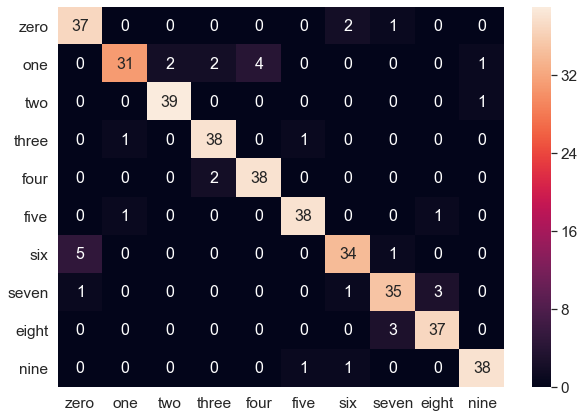

In [121]:
pred = digit_rfc.predict(digit_X_val)
cm = confusion_matrix(digit_y_val, pred)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in digit_feature_types],
                  columns = [i for i in digit_feature_types])
plt.figure(figsize = (10,7))

sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.show()

In [125]:
op_rfc = RandomForestClassifier(n_estimators = 150)
op_X_train, op_X_val, op_y_train, op_y_val = train_test_split(op_features, op_labels, test_size=0.2, random_state=10, shuffle = True, stratify=op_labels)
op_rfc.fit(op_X_train, op_y_train)

#checking the accuracy of the model
print(op_rfc.score(op_X_val, op_y_val))

0.9487179487179487


[[15  0  0  0]
 [ 0 14  0  0]
 [ 0  0 13  0]
 [ 0  0  0 14]]


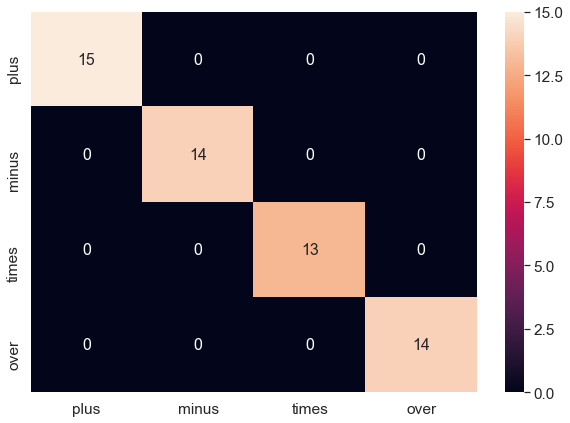

In [126]:
pred = op_rfc.predict(op_set)
cm = confusion_matrix(op_test_label, pred)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in op_feature_types],
                  columns = [i for i in op_feature_types])
plt.figure(figsize = (10,7))

sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.show()

In [16]:
print("Splitting")
X_train, X_val, y_train, y_val = train_test_split(digit_features, digit_labels, test_size=0.2, random_state=10, shuffle = True, stratify=digit_labels)

#print(X_train)

print("digit svm fitting...")

digit_svm = SVC(C=20.0, gamma=0.00001)
digit_svm.fit(X_train, y_train)
dig_test_acc = digit_svm.score(X_val, y_val)
dig_train_acc = digit_svm.score(X_train, y_train)
print("svm digit test accuracy =%0.3f" % dig_test_acc)
print("svm digit train accuracy =%0.3f" % dig_train_acc)

Splitting
digit svm fitting...
svm digit test accuracy =0.948
svm digit train accuracy =1.000


In [17]:
X_train, X_val, y_train, y_val = train_test_split(op_features, op_labels, test_size=0.2, random_state=10, shuffle = True, stratify=op_labels)

print('operator svm fitting...')
op_svm = SVC(C=20.0, gamma=0.00001)
op_svm.fit(X_train, y_train)
op_test_acc = op_svm.score(X_val, y_val)
op_train_acc = op_svm.score(X_train, y_train)
print("svm operator test accuracy=%0.3f" % op_test_acc)
print("svm operator train accuracy=%0.3f" % op_train_acc)

operator svm fitting...
svm operator test accuracy=0.936
svm operator train accuracy=1.000


In [18]:
X_train, X_val, y_train, y_val = train_test_split(digit_features, digit_labels, test_size=0.2, random_state=10, shuffle = True, stratify=digit_labels)

#print(X_train)

print("digit adaboost with logistic fitting...")

digit_ada_log = AdaBoostClassifier(LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = 'l2', max_iter = 10000), n_estimators=100, random_state=0)
digit_ada_log.fit(X_train, y_train)
dig_test_acc = digit_ada_log.score(X_val, y_val)
dig_train_acc = digit_ada_log.score(X_train, y_train)
print("digit adaboost with logistic test accuracy =%0.3f" % dig_test_acc)
print("digit adaboost with logistic train accuracy =%0.3f" % dig_train_acc)

digit adaboost with logistic fitting...
digit adaboost with logistic test accuracy =0.833
digit adaboost with logistic train accuracy =1.000


In [19]:
print("Splitting")
X_train, X_val, y_train, y_val = train_test_split(digit_features, digit_labels, test_size=0.2, random_state=10, shuffle = True, stratify=digit_labels)

#print(X_train)

print("digit adaboost with random forest fitting...")

digit_ada_rf = AdaBoostClassifier(RandomForestClassifier(n_estimators = 150), n_estimators=100, random_state=0)
digit_ada_rf.fit(X_train, y_train)
dig_test_acc = digit_ada_rf.score(X_val, y_val)
dig_train_acc = digit_ada_rf.score(X_train, y_train)
print("digit adaboost with random forest test accuracy =%0.3f" % dig_test_acc)
print("digit adaboost with random forest train accuracy =%0.3f" % dig_train_acc)

Splitting
digit adaboost with random forest fitting...
digit adaboost with random forest test accuracy =0.895
digit adaboost with random forest train accuracy =1.000


In [20]:
print("Splitting")
X_train, X_val, y_train, y_val = train_test_split(op_features, op_labels, test_size=0.2, random_state=10, shuffle = True, stratify=op_labels)

print("operator adaboost with logistic fitting...")

op_ada_log = AdaBoostClassifier(LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = 'l2', max_iter = 10000), n_estimators=100, random_state=0)
op_ada_log.fit(X_train, y_train)
op_test_acc = op_ada_log.score(X_val, y_val)
op_train_acc = op_ada_log.score(X_train, y_train)
print("operator adaboost with logistic test accuracy =%0.3f" % op_test_acc)
print("operator adaboost with logistic train accuracy =%0.3f" % op_train_acc)

Splitting
operator adaboost with logistic fitting...
operator adaboost with logistic test accuracy =0.936
operator adaboost with logistic train accuracy =1.000


In [21]:
X_train, X_val, y_train, y_val = train_test_split(op_features, op_labels, test_size=0.2, random_state=10, shuffle = True, stratify=op_labels)

print("operator adaboost with random forest fitting...")

op_ada_rf = AdaBoostClassifier(RandomForestClassifier(n_estimators = 150), n_estimators=100, random_state=0)
op_ada_rf.fit(X_train, y_train)
op_test_acc = op_ada_rf.score(X_val, y_val)
op_train_acc = op_ada_rf.score(X_train, y_train)
print("operator adaboost rf test accuracy =%0.3f" % op_test_acc)
print("operator adaboost rf train accuracy =%0.3f" % op_train_acc)

operator adaboost with random forest fitting...
operator adaboost rf test accuracy =0.949
operator adaboost rf train accuracy =1.000


In [ ]:
result.append(digit_svm.predict(acoustic_features.reshape(1, -1)))
result.append(digit_logisticRegr.predict(acoustic_features.reshape(1,-1)))
result.append(digit_rfc.predict(acoustic_features.reshape(1,-1)))
result.append(digit_ada_rf.predict(acoustic_features.reshape(1,-1)))
result.append(digit_ada_log.predict(acoustic_features.reshape(1,-1)))
        

In [72]:
models = ["svm", "logistic", "rf", "adaboost with rf", "adaboost with logistic"]


def test_sig(sig, rate, now = "digit", enable_plot = False):
    
    mfcc_feat = mfcc(sig, rate, nfft=1536)
    fbank_feat = logfbank(sig, rate, nfft=1536)
   
    acoustic_features = mfcc_feat
    acoustic_features = join_features(mfcc_feat, fbank_feat)
    acoustic_features = acoustic_features.flatten()
    
    result = []
    if now == "digit":
        #acoustic_features = digit_scaler.transform(acoustic_features.reshape(1,-1))
        #acoustic_features = digit_pca.transform(acoustic_features)
        #print(acoustic_features.shape)
        result.append(digit_svm.predict(acoustic_features.reshape(1, -1)))
        result.append(digit_logisticRegr.predict(acoustic_features.reshape(1,-1)))
        result.append(digit_rfc.predict(acoustic_features.reshape(1,-1)))
        result.append(digit_ada_rf.predict(acoustic_features.reshape(1,-1)))
        result.append(digit_ada_log.predict(acoustic_features.reshape(1,-1)))
    else:
        result.append(op_svm.predict(acoustic_features.reshape(1, -1)))
        result.append(op_logisticRegr.predict(acoustic_features.reshape(1,-1)))
        result.append(op_rfc.predict(acoustic_features.reshape(1,-1)))
        result.append(op_ada_rf.predict(acoustic_features.reshape(1,-1)))
        result.append(op_ada_log.predict(acoustic_features.reshape(1,-1)))
                 
    count = np.zeros(10)
    
    for i in range(0, 5):
        print(models[i], result[i])
        if now == "digit":
            for j in range(0, 10):
                if digit_feature_types[j] == result[i]:
                    count[j] = count[j] + 1
                    if i >= 3:
                        count[j] = count[j] + 1
                    break
        if now == "operator":
            for j in range(0, 5):
                if op_feature_types[j] == result[i]:
                    count[j] = count[j] + 1
                    if i >= 3:
                        count[j] = count[j] + 1
                    break
    return count



def read_and_test_file(directory, t = "digit", enable_plot = False):
    os.chdir(cwd+"\\recording data\\"+directory)
    files = glob.glob(os.path.join(os.getcwd(), '*.wav') )
    file_n = 0
    for file in files:
        file_n = file_n + 1
        now = t
        if now == "formula":
            if file_n % 2 == 1:
                now = "digit"
            else:
                now = "operator"
        (rate,sig) = wav.read(file)
        sig, sample_rate = librosa.core.load(file)
        sig = preprocess(sig)
        
        count = test_sig(sig, rate, now)
               
        print(file)     
        if t == "formula":
            if file_n == 1:
                digit1 = np.argmax(count)
            if file_n == 2:
                op = np.argmax(count)
            if file_n == 3:
                digit2 = np.argmax(count)
                print("\nFormula acquired!")
                print("The formula is: ", digit1, op_feature_types[op], digit2)
                
                if op == 0:
                    print("The answer is:", digit1 + digit2)
                if op == 1:
                    print("The answer is:", digit1 - digit2)
                if op == 2:
                    print("The answer is:", digit1 * digit2)
                if op == 3:
                    if digit2 == 0:
                        print("denominator couldn't be 0")
                    else:
                        print("The answer is:", digit1 / digit2)
    
truncate_threshold = 0.1
def truncate_and_test_audio_file(directory, filename):
    os.chdir(cwd+"\\recording data\\"+directory)
    file = glob.glob(os.path.join(os.getcwd(), filename) )[0]
    (rate,sig) = wav.read(file)
    sig, sample_rate = librosa.core.load(file)
    sig = preprocess(sig)
    
    norm_sig = normalize(sig)
    
    noise_start = 0
    noise_length = 0
    noise_end = 0
    for i in range(1, sig.size):
        if sig[i] < truncate_threshold:
            if noise_length == 0:
                noise_start = i
            noise_length = noise_length + 1
        else:
            if noise_length > 2400:
                noise_end = i
                break
            noise_length = 0
    
    sig1 = sig[0:noise_start]
    
    noise_start = 0
    noise_length = 0
    section_start = noise_end
    for i in range(section_start, sig.size):
        if sig[i] < truncate_threshold:
            if noise_length == 0:
                noise_start = i
            noise_length = noise_length + 1
        else:
            if noise_length > 2400:
                noise_end = i
                break
            noise_length = 0
    
    sig2 = sig[section_start:noise_start]
    sig3 = sig[noise_end:]
    
    sig1 = librosa.core.resample(sig1, sig1.size, truncate_size)
    sig2 = librosa.core.resample(sig2, sig2.size, truncate_size)
    sig3 = librosa.core.resample(sig3, sig3.size, truncate_size)
    
    digit1 = np.argmax(test_sig(sig1, rate, "digit"))
    op = np.argmax(test_sig(sig2, rate, "op"))
    digit2 = np.argmax(test_sig(sig3, rate, "digit"))
    
    plot_sig(sig, "sig")
    plot_sig(sig1, "sig1")
    plot_sig(sig2, "sig2")
    plot_sig(sig3, "sig3")
    
    print("\nFormula acquired!")
    print("The formula is: ", digit1, op_feature_types[op], digit2)
    
    if op == 0:
        print("The answer is:", digit1 + digit2)
    if op == 1:
        print("The answer is:", digit1 - digit2)
    if op == 2:
        print("The answer is:", digit1 * digit2)
    if op == 3:
        if digit2 == 0:
            print("denominator couldn't be 0")
        else:
            print("The answer is:", digit1 / digit2)
    

In [73]:
read_and_test_file("formula", "formula", False)

svm ['nine']
logistic ['six']
rf ['five']
adaboost with rf ['five']
adaboost with logistic ['seven']
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\formula\1.wav
svm ['plus']
logistic ['plus']
rf ['plus']
adaboost with rf ['plus']
adaboost with logistic ['plus']
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\formula\2.wav
svm ['four']
logistic ['one']
rf ['four']
adaboost with rf ['four']
adaboost with logistic ['one']
C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\formula\3.wav

Formula acquired!
The formula is:  5 plus 4
The answer is: 9


svm ['one']
logistic ['one']
rf ['six']
adaboost with rf ['six']
adaboost with logistic ['one']
svm ['plus']
logistic ['plus']
rf ['over']
adaboost with rf ['over']
adaboost with logistic ['plus']
svm ['six']
logistic ['one']
rf ['four']
adaboost with rf ['four']
adaboost with logistic ['four']


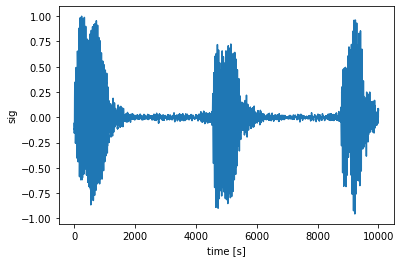

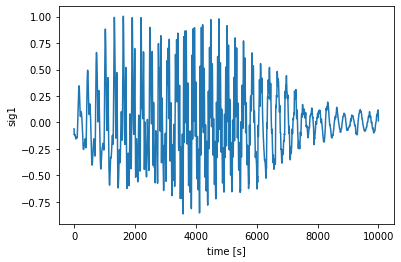

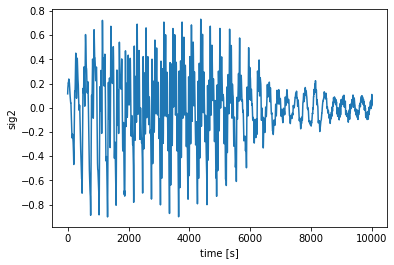

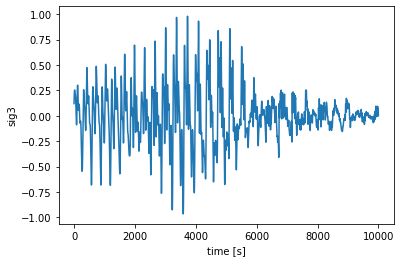


Formula acquired!
The formula is:  1 plus 4
The answer is: 5


In [74]:
truncate_and_test_audio_file("singleFile","1+4.wav")